In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding, Isomap, TSNE
import umap
import GPy
import seaborn as sns
from sklearn.datasets import load_digits

import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)

/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

In [2]:
digits = load_digits()
print(digits['data'])
print(digits.target)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
[0 1 2 ... 8 9 8]


In [3]:
def visualize(z_pred, method):
    for i in range(10):
        idx = digits.target == i
        plt.plot(z_pred[idx, 0], z_pred[idx, 1], '.', label=f'{i}')
    plt.legend()
    plt.title(f'{method}')

In [4]:
d_latent = 2
x = digits['data']

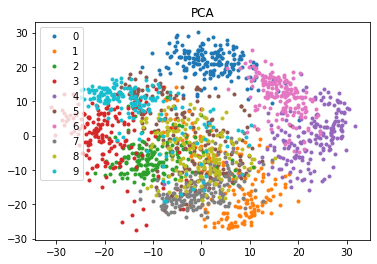

In [30]:
visualize(PCA(n_components=d_latent).fit_transform(x), 'PCA')

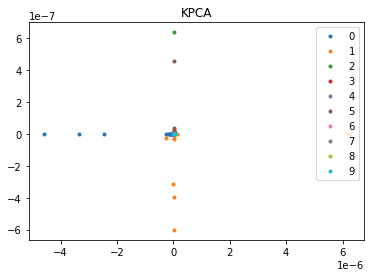

In [33]:
visualize(KernelPCA(n_components=d_latent, kernel='sigmoid').fit_transform(x), 'KPCA')

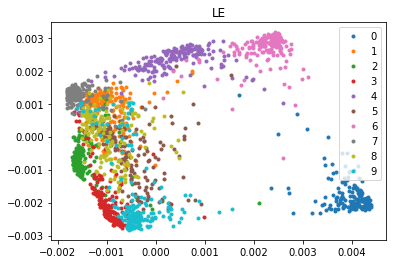

In [34]:
visualize(SpectralEmbedding(n_components=d_latent).fit_transform(x), 'LE')

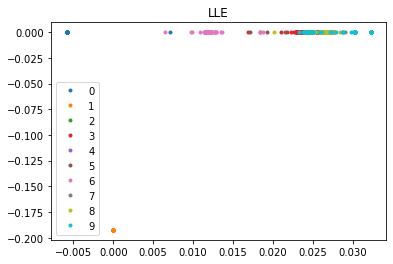

In [35]:
visualize(LocallyLinearEmbedding(n_components=d_latent).fit_transform(x), 'LLE')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


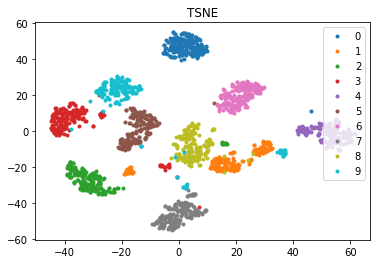

In [36]:
visualize(TSNE(n_components=d_latent, init='pca', learning_rate='auto', random_state=42).fit_transform(x), 'TSNE')

 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:324: UserWarning:The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
 /storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


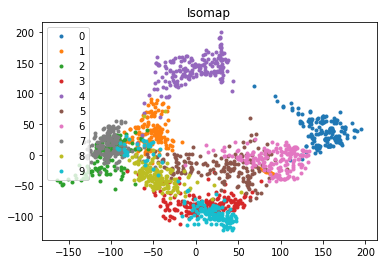

In [37]:
visualize(Isomap(n_components=d_latent).fit_transform(x), 'Isomap')

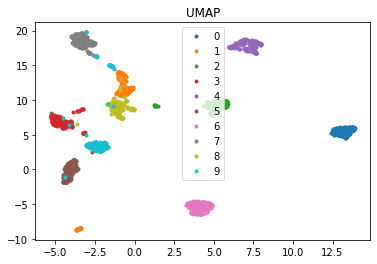

In [38]:
visualize(umap.UMAP(n_components=d_latent, random_state=42).fit_transform(x), 'UMAP')

Too many remaining indices, use nearest neighbors to find all cliques for every points
Clique threshold: 0.6, number of cliques: 232


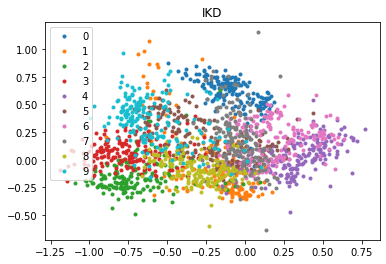

In [24]:
visualize(core.ikd_blockwise(x, d_latent=d_latent, clique_th=0.6, max_n_cliques=2), 'IKD')

Only one clique, identical to full eigen-decomposition


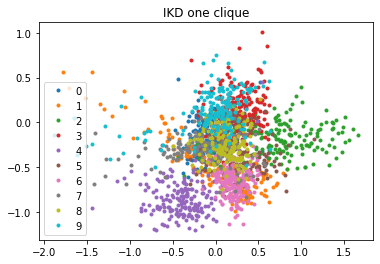

In [32]:
visualize(core.ikd_blockwise(x, d_latent=2, clique_th=0, max_n_cliques=2), 'IKD one clique')

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   7.726302e+05           nan 
    04s44  0012   3.001751e+05   2.572039e+06 
    14s23  0039   2.603039e+05   6.062784e+06 
    41s32  0114   2.529726e+05   2.919536e+05 
 01m56s88  0324   2.521721e+05   7.404183e+04 
 05m28s95  0909   2.519403e+05   1.471947e+04 
 06m02s43  1002   2.519249e+05   2.134095e+02 
Runtime:  06m02s43
Optimization status: Maximum number of f evaluations reached



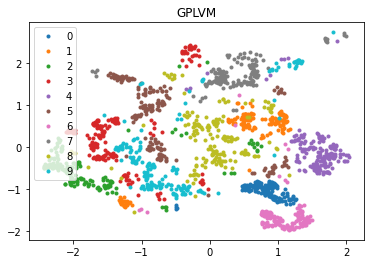

In [25]:
m_gplvm = GPy.models.GPLVM(x, d_latent, kernel=GPy.kern.RBF(d_latent, variance=1, lengthscale=1))
m_gplvm.likelihood.variance = 1.
m_gplvm.optimize(max_iters=1e3, messages=1)
visualize(m_gplvm.X.values, 'GPLVM')

如果已经知道距离了，那么直接取平方再取相反数，然后直接 IKD？

！！！ 本质上是更复杂的 GP 过程，生成协方差矩阵的核更复杂了